<img src="https://raw.githubusercontent.com/Sengsathit/OCR_data_scientist_assets/main/header_place_de_marche.png" alt="Alternative text" />

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Initialisation](#toc2_)    
  - [Importation et configurations](#toc2_1_)    
  - [Chargement des données](#toc2_2_)    
- [Aperçu global des données](#toc3_)    
- [Nettoyage & Feature Engineering](#toc4_)    
- [Analyse exploratoire](#toc5_)    
- [Étude de faisabilité : NLP](#toc6_)    
  - [Fonctions ré-utilisables](#toc6_1_)    
  - [Corpus & Tokenisation](#toc6_2_)    
  - [Méthodes basiques](#toc6_3_)    
    - [Bag of Words](#toc6_3_1_)    
    - [TF-IDF](#toc6_3_2_)    
  - [Méthodes avancées](#toc6_4_)    
    - [Word2Vec](#toc6_4_1_)    
    - [BERT (Bidirectional Encoder Representations from Transformers)](#toc6_4_2_)    
    - [USE (Universal Sentence Encoder)](#toc6_4_3_)    
- [Étude de faisabilité : Computer Vision](#toc7_)    
  - [Chargement des données](#toc7_1_)    
  - [Exploration et feature engineering](#toc7_2_)    
  - [Fonctions ré-utilisables pour le Computer Vision](#toc7_3_)    
  - [Méthode basique : SIFT](#toc7_4_)    
    - [Exemple de traitement d'image : extraction de descripteurs](#toc7_4_1_)    
    - [Extraction des descripteurs locaux propres à chaque image](#toc7_4_2_)    
  - [Bag of Visual Words (BoVW) : descripteurs globaux](#toc7_5_)    
    - [Histogrammes de mots visuels](#toc7_5_1_)    
    - [Exemples d'histogramme](#toc7_5_2_)    
  - [Analyse visuelle : affichage T-SNE](#toc7_6_)    
  - [Méthode avancée : CNN Transfer Learning](#toc7_7_)    
    - [Extraction des features locales propres à chaque images](#toc7_7_1_)    
    - [Bag of Visual Words (BoVW) : features globales](#toc7_7_2_)    
      - [Histogrammes de mots visuels](#toc7_7_2_1_)    
      - [Exemples d'histogramme](#toc7_7_2_2_)    
    - [Analyse visuelle : affichage T-SNE](#toc7_7_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)

Ce notebook vise à évaluer la faisabilité de la classification des produits de consommation en utilisant le traitement du langage naturel (NLP) et le Computer Vision.

Pour le traitement du langage naturel, des techniques comme la lemmatisation sont appliquées ainsi que des techniques de vectorisation des mots tels que Word2Vec et BERT.\
Nous utilisons ensuite un modèle de réseau de neurones convolutionnel (CNN) pré-entraîné, VGG16, pour la classification des images de produits.

Nous évaluons la faisabilité de regrouper les produits similaires à l'aide de techniques de clustering comme KMeans. Pour cela, nous visualisons les résultats avec des méthodes de réduction de dimensionnalité comme TSNE, et nous utilisons des métriques telles que Adjusted Rand Index (ARI) pour quantifier la qualité du clustering.

# <a id='toc2_'></a>[Initialisation](#toc0_)

## <a id='toc2_1_'></a>[Importation et configurations](#toc0_)

In [1]:
# Bibliothèque standard
import re, random
from os import listdir

# Modèles
import pickle

# Manipulation des données
import numpy as np
import pandas as pd

# NLP
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from scipy.sparse import spmatrix
import tensorflow_hub as hub
import torch

# CNN
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import cv2

random.seed(42)
np.random.seed(42)

# Configurer Pandas pour un affichage complet du contenu des colonnes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams['figure.facecolor'] = '#FFFCF7'    # Définir la couleur de fond de la figure
plt.rcParams['axes.facecolor'] = '#FFFCF7'      # Définir la couleur de fond des axes

# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('punkt')

/var/folders/59/q0j81gmx5h7gvpg38k8hknzw0000gn/T/ipykernel_32025/465168207.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## <a id='toc2_2_'></a>[Chargement des données](#toc0_)

In [2]:
df = pd.read_csv('../datasets/flipkart/flipkart_com-ecommerce_sample_1050.csv')

# <a id='toc3_'></a>[Aperçu global des données](#toc0_)

In [3]:
df.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                                                                                                  product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
1                                  http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the rig

In [4]:
df.shape

(1050, 15)

In [5]:
df.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

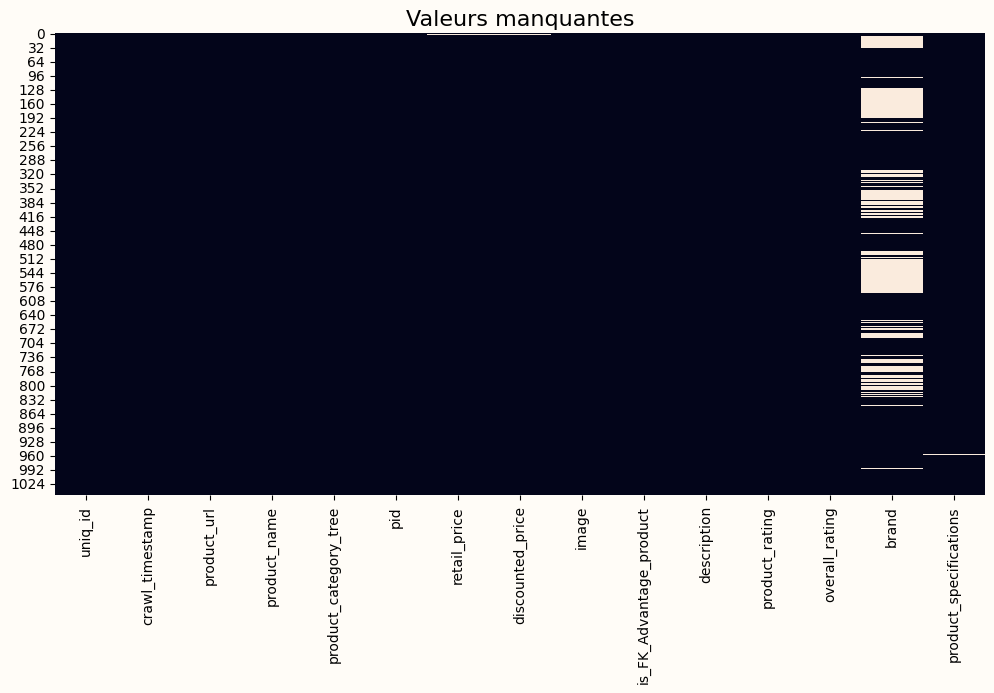

In [6]:
plt.figure(figsize=(12,6))
plt.title('Valeurs manquantes', fontsize=16)
sns.heatmap(df.isna(), cbar=False)
plt.show()

In [7]:
display(df.isna().any())
display(df.isna().sum().sort_values(ascending=False))

uniq_id                    False
crawl_timestamp            False
product_url                False
product_name               False
product_category_tree      False
pid                        False
retail_price                True
discounted_price            True
image                      False
is_FK_Advantage_product    False
description                False
product_rating             False
overall_rating             False
brand                       True
product_specifications      True
dtype: bool

brand                      338
retail_price                 1
discounted_price             1
product_specifications       1
uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
dtype: int64

In [8]:
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

# <a id='toc4_'></a>[Nettoyage & Feature Engineering](#toc0_)

Cette section du notebook traite de la préparation des données pour les modèles que nous allons utilser pour faire l'étude de faisabilité.\
Elle extrait et nettoie des colonnes spécifiques du dataframe, encode les catégories de produits en labels numériques, et sauvegarde le mapping des labels à l'aide de LabelEncoder pour une utilisation future.

In [9]:
# Copie des colonnes spécifiques du DataFrame original
df_cleaned = df[['uniq_id', 'image', 'product_name', 'description']].copy()

# Extraction et création d'une nouvelle colonne '_category' en appliquant une regex sur 'product_category_tree'
df_cleaned['_category'] = df['product_category_tree'].apply(lambda x: re.search(r'\["(.*?) >>', x).group(1).lower())

# Encoder les labels de la colonne '_category' et sauvegarder le mapping dans un fichier
encoder = LabelEncoder().fit(df_cleaned['_category'])
with open('../models/label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Charger le mapping des labels à partir du fichier sauvegardé
with open('../models/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Transformer les catégories en labels encodés et ajouter la colonne '_label' dans le DataFrame
labels_encoded = label_encoder.transform(df_cleaned['_category'])
df_cleaned['_label'] = labels_encoded

df_cleaned.to_csv('../datasets/flipkart_cleaned.csv', index=False)

# <a id='toc5_'></a>[Analyse exploratoire](#toc0_)

In [10]:
df_cleaned.sample(2)

uniq_id                                 image  \
352  833a87b0af3b84fe246d2ebf271af177  833a87b0af3b84fe246d2ebf271af177.jpg   
689  55195de3873fffaa9e37b041533d7305  55195de3873fffaa9e37b041533d7305.jpg   

                                 product_name  \
352                            Zyxel PLA-4205   
689  Philips 9.5 W LED B22 3000K A55 IND Bulb   

                                                                                                                                                                                                             description  \
352                                                                        Buy Zyxel PLA-4205 only for Rs. 8100 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!   
689  Buy Philips 9.5 W LED B22 3000K A55 IND Bulb for Rs.419 online. Philips 9.5 W LED B22 3000K A55 IND Bulb at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.   

            _category  _label  
352         computers       2  
689  kitchen & dining       5

In [11]:
df_cleaned.isna().sum()

uniq_id         0
image           0
product_name    0
description     0
_category       0
_label          0
dtype: int64

In [12]:
df_cleaned['_category'].value_counts()

_category
home furnishing               150
baby care                     150
watches                       150
home decor & festive needs    150
kitchen & dining              150
beauty and personal care      150
computers                     150
Name: count, dtype: int64

# <a id='toc6_'></a>[Étude de faisabilité : NLP](#toc0_)

Cette partie examine la possibilité de classer les produits en fonction de leurs descriptions. Pour cela, nous utilisons des techniques de traitement du langage naturel (NLP)

## <a id='toc6_1_'></a>[Fonctions ré-utilisables](#toc0_)

In [13]:
def transform_document(
        doc: str, 
        lem_or_stem: str = 'stem',
        raw_cleaning: bool = False
        ):
    
    """
    Transforme un document texte en une version nettoyée et normalisée.

    Cette fonction convertit le texte en minuscules, le tokenize en mots, 
    enlève les stopwords (si `raw_cleaning` est False), et applique la lemmatisation ou 
    le stemming selon le paramètre `lem_or_stem`. Les tokens non alphabétiques et les 
    mots d'une seule lettre sont également supprimés.

    Args:
        doc (str): Le document texte à transformer.
        lem_or_stem (str): Spécifie le type de transformation à appliquer :
                           'lem' pour la lemmatisation, 'stem' pour le stemming.
                           Par défaut, 'stem'.
        raw_cleaning (bool): Si True, ne filtre pas les stopwords.
                             Par défaut, False.

    Returns:
        str: Le document transformé sous forme de chaîne de caractères.
    """
    
    # Convertir en minuscules et supprimer les espaces en trop
    doc = doc.lower().strip()

    # Tokenisation en utilisant des expressions régulières pour capturer les mots
    raw_tokens_list = RegexpTokenizer(r'\w+').tokenize(doc)
    
    if raw_cleaning:
        cleaned_tokens_list = raw_tokens_list
    else :
        # Suppression des stopwords
        cleaned_tokens_list = [word for word in raw_tokens_list if word not in stopwords.words('english')]

        # Lemmatisation ou stemming basé sur le paramètre lem_or_stem
        if lem_or_stem == 'lem':
            transformer = WordNetLemmatizer()
            cleaned_tokens_list = [transformer.lemmatize(token) for token in cleaned_tokens_list]
        else:
            transformer = PorterStemmer()
            cleaned_tokens_list = [transformer.stem(token) for token in cleaned_tokens_list]

    # Suppression des mots non alphabétiques et des mots d'une seule lettre
    cleaned_tokens_list = [word for word in cleaned_tokens_list if word.isalpha() and len(word) > 1]
        
    return ' '.join(cleaned_tokens_list)

In [14]:
def scale_matrix(matrix):
    """
    Applique un scaling robuste à une matrice sans recentrage.

    Cette fonction utilise `RobustScaler` de `sklearn` pour mettre à l'échelle
    les valeurs de la matrice donnée.

    Args:
        matrix (array-like): La matrice à mettre à l'échelle.

    Returns:
        array-like: La matrice mise à l'échelle.
    """

    scaler = RobustScaler(with_centering=False)
    matrix_scaled = scaler.fit_transform(matrix)
        
    return matrix_scaled

In [15]:
def visualize_scree_plot(matrix: spmatrix, n_components: int = 50, title: str = 'Éboulis des valeurs propres'):

    """
    Visualise le scree plot pour une matrice de données.

    Cette fonction standardise la matrice, réduit sa dimensionnalité à l'aide de 
    TruncatedSVD, puis trace le scree plot de la variance expliquée cumulée par 
    les composantes principales.

    Args:
        matrix (spmatrix): La matrice de données sparse à analyser.
        n_components (int): Le nombre de composantes principales à conserver.
                            Par défaut, 50.
        title (str): Le titre du graphique.

    Returns:
        None: La fonction affiche le scree plot mais ne retourne aucune valeur.
    """
    
    # Standardisation de la matrice
    matrix_scaled = scale_matrix(matrix)

    # Réduction de la dimensionnalité avec TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(matrix_scaled)

    # Calcul de la variance expliquée cumulée
    explained_variance = svd.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Tracer l'éboulis
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o')
    plt.xlabel('Nombre de composantes')
    plt.ylabel('Variance expliquée cumulée')
    plt.title(title)
    plt.grid(True)
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% variance expliquée')
    plt.legend(loc='best')
    plt.show()

In [16]:
def visualize_categories_nlp(
        matrix: spmatrix, 
        n_components_svd: int = 50, 
        labels: list = [], 
        title: str = 'Représentation des produits par catégories'
        ) -> np.ndarray:
    
    """
    Visualise les catégories de produits en utilisant une réduction de dimensionnalité sur une matrice.

    Cette fonction standardise la matrice, réduit sa dimensionnalité avec TruncatedSVD et t-SNE,
    puis visualise les catégories de produits à l'aide d'un scatter plot.

    Args:
        matrix (spmatrix): La matrice creuse de données.
        n_components_svd (int): Le nombre de composantes principales à conserver pour la réduction de dimensionnalité avec SVD.
                                Par défaut, 50.
        labels (list): La liste des labels des catégories pour chaque produit.
        title (str): Le titre du graphique.

    Returns:
        np.ndarray : Les caractéristiques transformées par t-SNE.
    """
    
    # Mapper le labels
    with open('../models/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    labels_encoded = label_encoder.fit_transform(labels)
    label_mapping = dict(zip(range(len(np.unique(labels))), np.unique(labels)))

    # Standardisation de la matrice
    matrix_scaled = scale_matrix(matrix)

    # Réduction de la dimensionnalité avec TruncatedSVD
    svd = TruncatedSVD(n_components=n_components_svd, random_state=42)
    X_svd = svd.fit_transform(matrix_scaled)

    # Réduction de la dimensionnalité avec t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X_svd)

    # Création d'un DataFrame pour la visualisation avec Seaborn
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
    df_tsne['label'] = labels_encoded
    df_tsne['category'] = df_tsne['label'].map(label_mapping)

    # Visualisation des résultats t-SNE
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='category', palette='tab10', data=df_tsne, edgecolor='w')
    plt.title(title)
    plt.xlabel('Composant 1')
    plt.ylabel('Composant 2')
    plt.legend(title='Catégories')
    plt.show()

    return X_tsne

In [17]:
def check_ari_nlp(matrix: spmatrix, df_data: pd.DataFrame, title: str): 

    """
    Calcule et affiche le score ARI (Adjusted Rand Index) pour une matrice.

    Cette fonction réduit la dimensionnalité de la matrice en utilisant les deux premières 
    composantes, applique un clustering avec KMeans, puis compare les clusters prédits 
    avec les labels réels en utilisant le score ARI.

    Args:
        matrix (spmatrix): La matrice creuse de données à analyser.
        df_data (pd.DataFrame): Le DataFrame contenant les informations de catégories et de labels.
        title (str): Le titre du résultat à afficher.

    Returns:
        None: La fonction imprime le score ARI et ne retourne aucune valeur.
    """

    df_tsne = pd.DataFrame(matrix[:,0:2], columns=['tsne_1', 'tsne_2'])
    df_tsne.index = df_data.index
    df_tsne['category'] = df_data['_category']
    df_tsne['label'] = df_data['_label']
    
    k = len(df_tsne['label'].unique())
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(matrix)
    df_tsne['cluster'] = kmeans.labels_

    print(f"{title}", adjusted_rand_score(df_tsne['label'], df_tsne['cluster']))

    return df_tsne

In [18]:
def visualize_tsne(df_data: pd.DataFrame, hue: str, title: str, palette: str):
    """
    Visualise les catégories d'un DataFrame en utilisant une représentation t-SNE et un scatter plot avec Seaborn.

    Parameters:
    -----------
    df_data : pd.DataFrame
        DataFrame contenant les données à visualiser, incluant les colonnes 'tsne_1' et 'tsne_2' pour les coordonnées t-SNE.
    hue : str
        Nom de la colonne dans df_data à utiliser pour la couleur des points (catégorisation par couleur).
    title : str
        Titre du graphique.
    palette : str
        Palette de couleurs à utiliser pour les catégories.

    Returns:
    --------
    None
        Cette fonction affiche directement le graphique et ne retourne aucune valeur.
    """
    
    plt.figure(figsize=(12, 8))
    
    sns.scatterplot(
        x='tsne_1', 
        y='tsne_2', 
        hue=hue, 
        data=df_data,
        palette=palette
    )

    plt.title(title)
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    
    plt.legend() 
    
    plt.show()

## <a id='toc6_2_'></a>[Corpus & Tokenisation](#toc0_)

Cette section a pour but de crée un corpus unique de mots à partir des descriptions tokenisées. Elle applique une fonction de transformation aux descriptions pour générer des versions nettoyées et normalisées des textes, puis sauvegarde le dataframe résultant dans un fichier CSV.

In [48]:
# Appliquer une transformation de nettoyage brut aux descriptions de produits
df_cleaned['_raw_tokenized'] = df['description'].apply(lambda x: transform_document(x, raw_cleaning=True))

# Appliquer une transformation avec stemming aux descriptions de produits
df_cleaned['_tokenized'] = df['description'].apply(lambda x: transform_document(x, lem_or_stem='stem'))

# Sauvegarder le DataFrame nettoyé dans un fichier CSV
df_cleaned.to_csv('../datasets/flipkart.csv', index=False)

# Afficher un échantillon de 2 lignes du DataFrame nettoyé
df_cleaned.sample(2)

uniq_id                                 image  \
186  8bf65b132179faf26f61e26274b2b819  8bf65b132179faf26f61e26274b2b819.jpg   
874  da8017c195b3bfa4ef002968a3542707  da8017c195b3bfa4ef002968a3542707.jpg   

                                 product_name  \
186  Rockmantra Gamming Wallpaper Ceramic Mug   
874                Mafatlal Cotton Bath Towel   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               description  \
186  Rockmantra Gamming Wallpaper Ceramic Mug (5.5 l)\r\n                         Price: Rs. 349\r\n\t\t\t\t\r\n\t\t\tGive a thrilling yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :\rMaterial : Ceramic\rSize : 3.5" X 4"\r\nGive a thrilling yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :\rMaterial : Ceramic\rSize : 3.5" X 4"   
874                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Buy Mafatlal Cotton Bath Towel at Rs. 545 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!   

            _category  _label  \
186  kitchen & dining       5   
874   home furnishing       4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        _raw_tokenized  \
186  rockmantra gamming wallpaper ceramic mug price rs give thrilling yet fresh start to your day an exclusive creation by rockmantra this mug features porcelain crafting ensuring the design stays permanent for years to come and making it perfect pick to gift your loved ones too dishwasher and microwave safe product details and specifications material ceramic size give thrilling yet fresh start to your day an exclusive creation by rockmantra this mug features por

## <a id='toc6_3_'></a>[Méthodes basiques](#toc0_)

Dans cette section, nous allons explorer des méthodes basiques de traitement automatique du langage naturel (NLP) telles que le Bag-of-Words et le TF-IDF. Ces techniques nous permettront de mieux comprendre et analyser les données textuelles en mettant en évidence la fréquence et l'importance des mots au sein des documents et du corpus.

### <a id='toc6_3_1_'></a>[Bag of Words](#toc0_)

Chaque document est représenté par un vecteur de fréquences de mots. Les simples comptages se basent uniquement sur les comptages bruts de chaque mot.

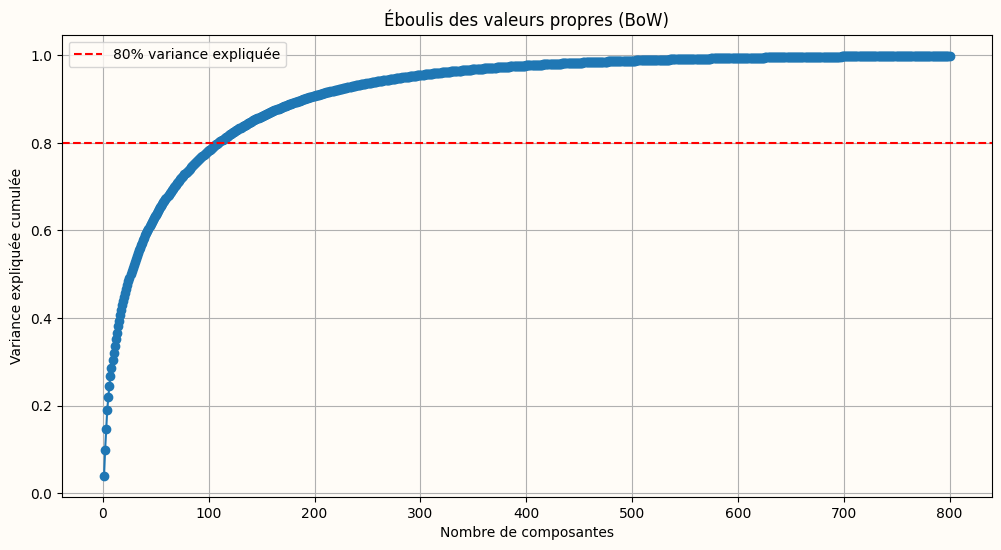

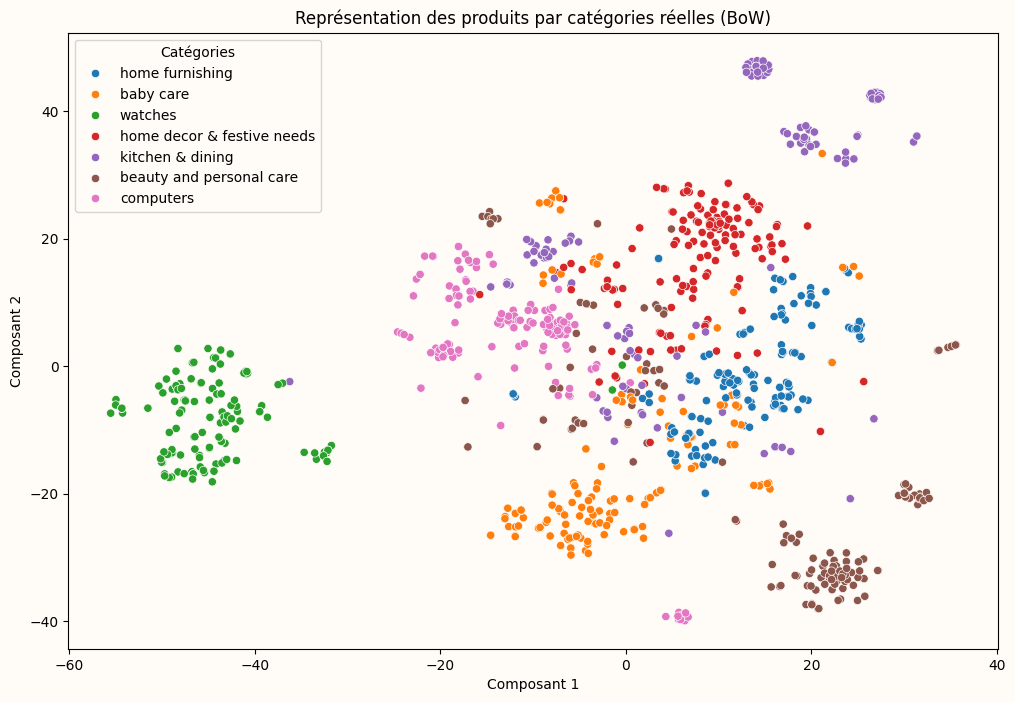

ARI pour BoW 0.4705899797674297


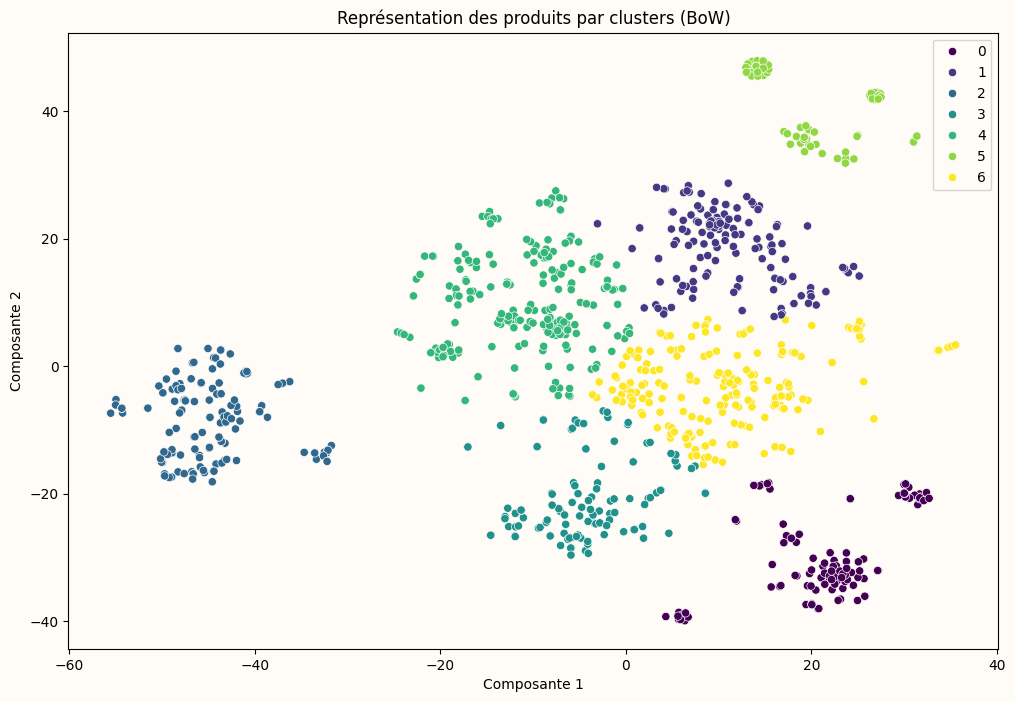

In [20]:
documents = df_cleaned['_tokenized'].tolist()
labels = df_cleaned['_category'].tolist()

vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(documents)

# Détermination du nombre de composants minimum pour capter un taux de variance acceptable. Ce nombre de composants est utilisé pour la réduction de dimensions.
visualize_scree_plot(
    matrix=X_bow, 
    n_components=800,
    title='Éboulis des valeurs propres (BoW)'
)

matrix_tsne_bow = visualize_categories_nlp(
    matrix=X_bow, 
    n_components_svd=400, 
    labels=labels, 
    title='Représentation des produits par catégories réelles (BoW)'
)

df_tsne_bow = check_ari_nlp(
    matrix=matrix_tsne_bow,
    df_data=df_cleaned,
    title='ARI pour BoW'
)

visualize_tsne(
    df_data=df_tsne_bow, 
    hue='cluster', 
    title='Représentation des produits par clusters (BoW)',
    palette='viridis'
)

### <a id='toc6_3_2_'></a>[TF-IDF](#toc0_)

Chaque document est représenté par un vecteur de scores TF-IDF. Le score TF-IDF est une pondération qui prend en compte la fréquence des mots dans un document (TF) et leur inverse fréquence dans l'ensemble du corpus (IDF).

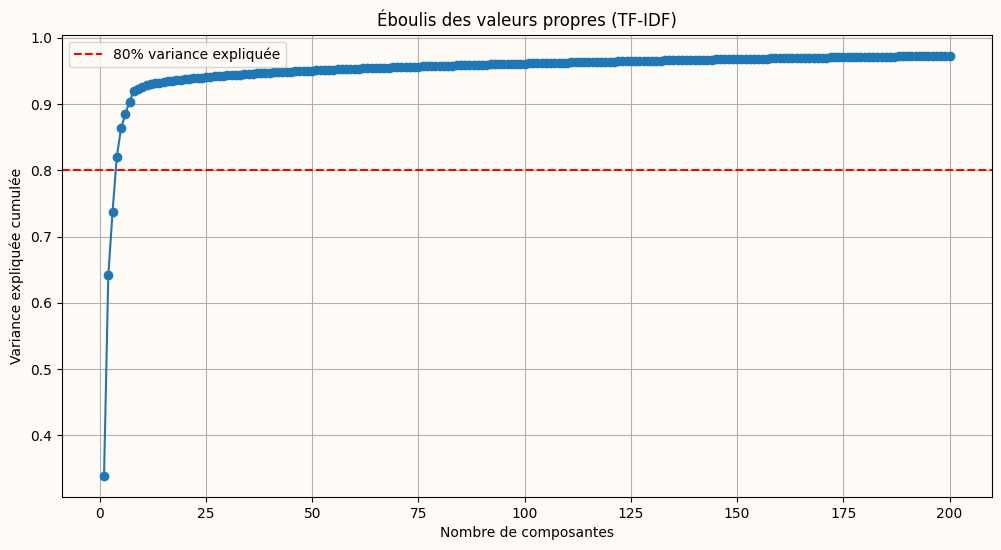

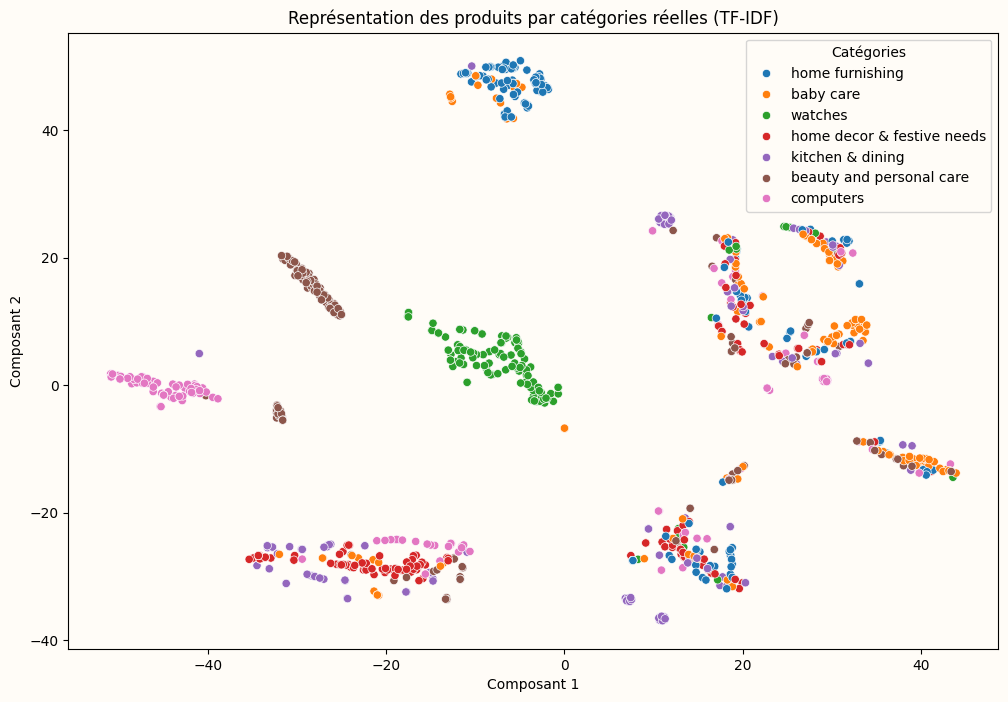

ARI pour TF-IDF 0.21948499022950668


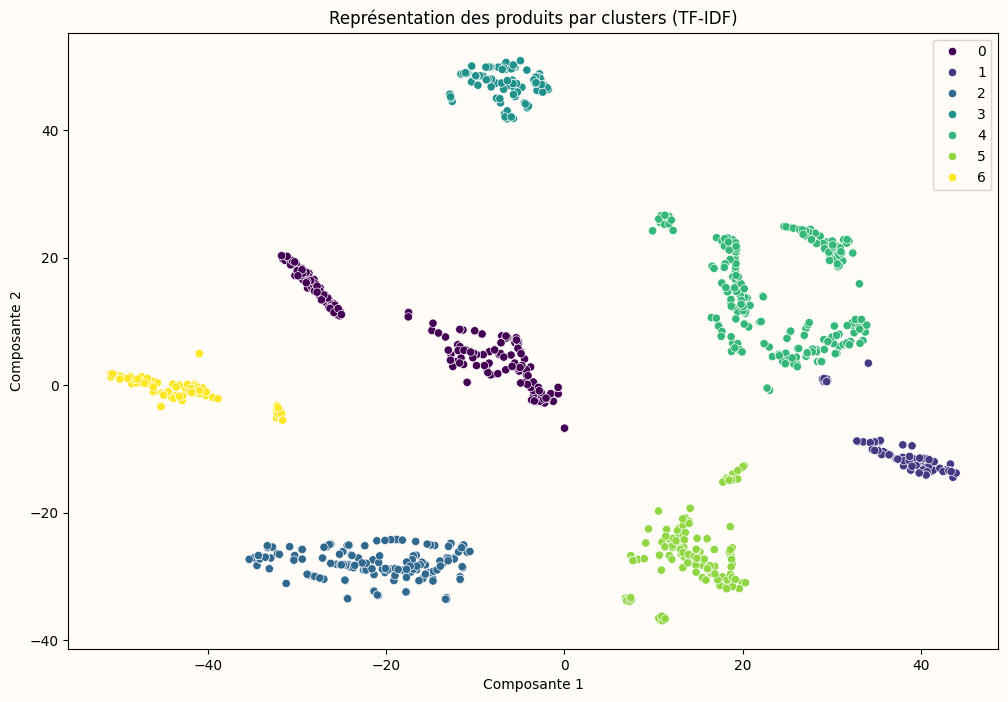

In [21]:
documents = df_cleaned['_tokenized'].tolist()
labels = df_cleaned['_category'].tolist()

vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(documents)

# Détermination du nombre de composants minimum pour capter un taux de variance acceptable. Ce nombre de composants est utilisé pour la réduction de dimensions.
visualize_scree_plot(
    matrix=X_tfidf, 
    n_components=200,
    title='Éboulis des valeurs propres (TF-IDF)'
)

matrix_tsne_tfidf = visualize_categories_nlp(
    matrix=X_tfidf, 
    n_components_svd=50, 
    labels=labels, 
    title='Représentation des produits par catégories réelles (TF-IDF)'
)

df_tsne_tfidf = check_ari_nlp(
    matrix=matrix_tsne_tfidf, 
    df_data=df_cleaned,
    title='ARI pour TF-IDF'
)

visualize_tsne(
    df_data=df_tsne_tfidf, 
    hue='cluster', 
    title='Représentation des produits par clusters (TF-IDF)',
    palette='viridis'
)

## <a id='toc6_4_'></a>[Méthodes avancées](#toc0_)

### <a id='toc6_4_1_'></a>[Word2Vec](#toc0_)

Chaque document est représenté par un vecteur Word2Vec. Word2Vec utilise des techniques d'apprentissage profond pour capturer les relations contextuelles entre les mots.

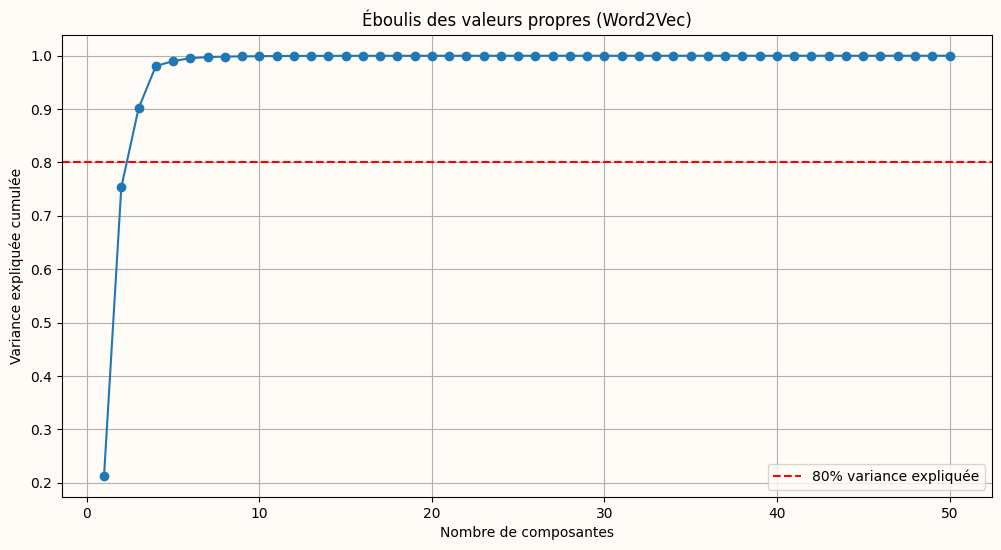

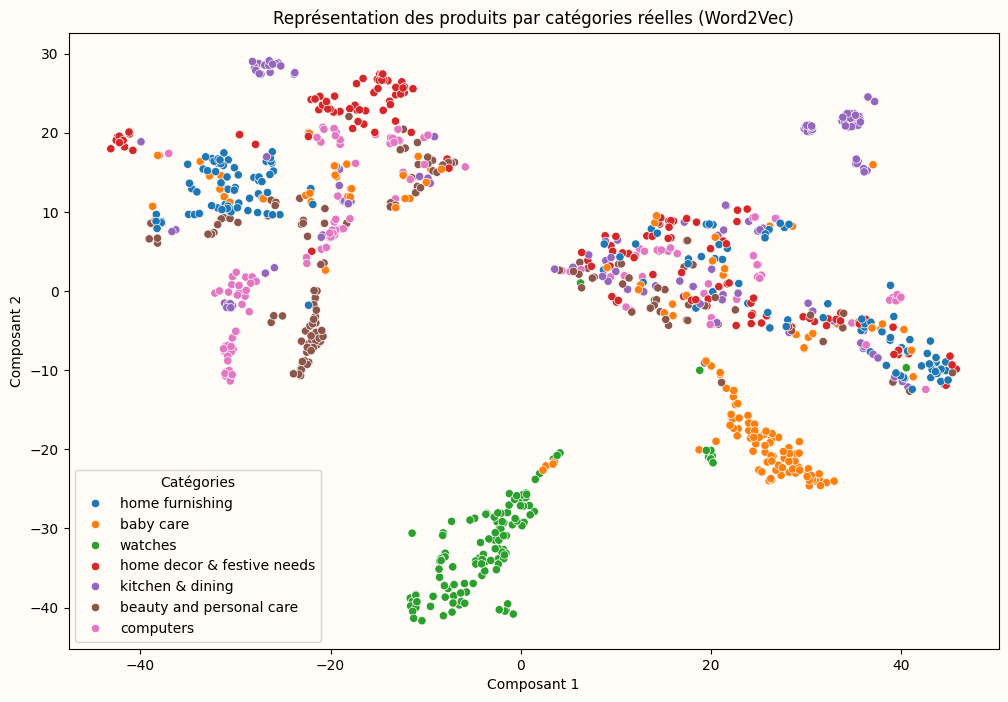

ARI pour Word2Vec 0.24645409810070046


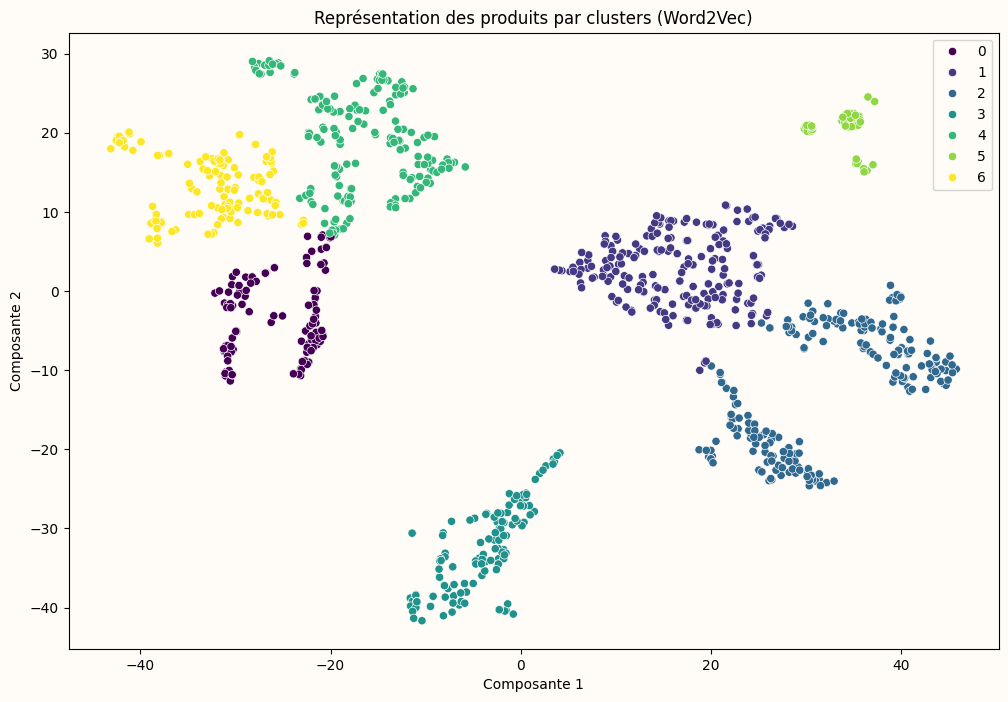

In [22]:
data = df_cleaned['_tokenized'].tolist()
labels = df_cleaned['_category'].tolist()

documents = []
for document in data:
    documents.append([word for word in document.split()])
    
# Fonction pour calculer le vecteur moyen d'un document
def document_vector(model, doc):
    return np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)

model = Word2Vec(sentences=documents, vector_size=300, window=5, min_count=1, workers=4, seed=42)

X_word2vec = np.array([document_vector(model, doc) for doc in documents])

# Détermination du nombre de composants minimum pour capter un taux de variance acceptable. Ce nombre de composants est utilisé pour la réduction de dimensions.
visualize_scree_plot(
    matrix=X_word2vec, 
    n_components=50,
    title='Éboulis des valeurs propres (Word2Vec)'
)

matrix_tsne_word2vec = visualize_categories_nlp(
    matrix=X_word2vec, 
    n_components_svd=50, 
    labels=labels, 
    title='Représentation des produits par catégories réelles (Word2Vec)'
)

df_tsne_word2vec = check_ari_nlp(
    matrix=matrix_tsne_word2vec, 
    df_data=df_cleaned,
    title='ARI pour Word2Vec'
)

visualize_tsne(
    df_data=df_tsne_word2vec, 
    hue='cluster', 
    title='Représentation des produits par clusters (Word2Vec)',
    palette='viridis'
)

### <a id='toc6_4_2_'></a>[BERT (Bidirectional Encoder Representations from Transformers)](#toc0_)

BERT génère des représentations contextuelles des mots, il utilise des modèles de langage avancés pour comprendre le contexte et les relations entre les mots dans un texte, en tenant compte des mots qui viennent avant et après dans la phrase.

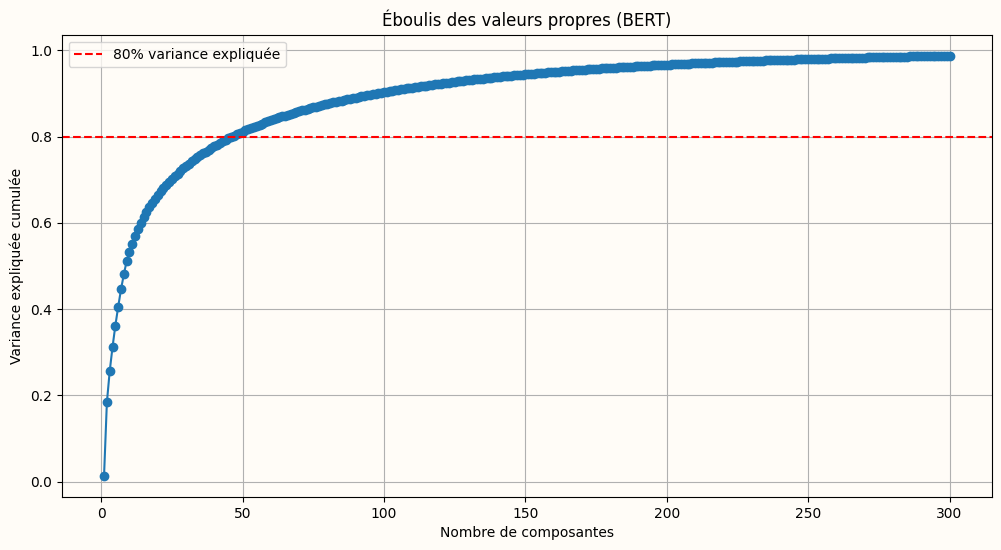

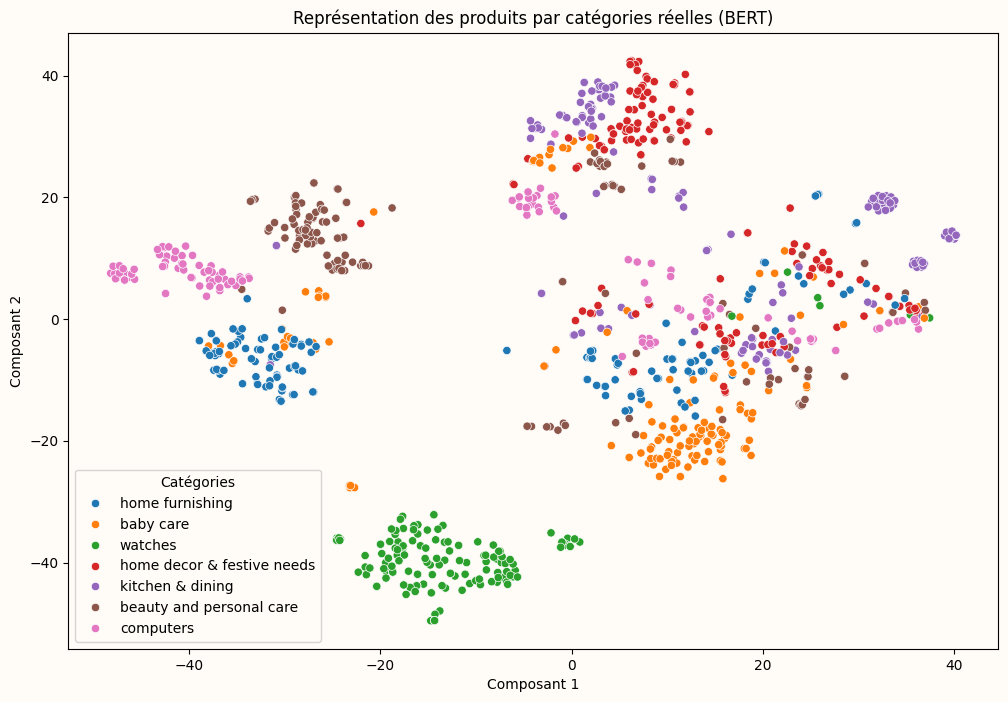

ARI pour BERT 0.3162105509872174


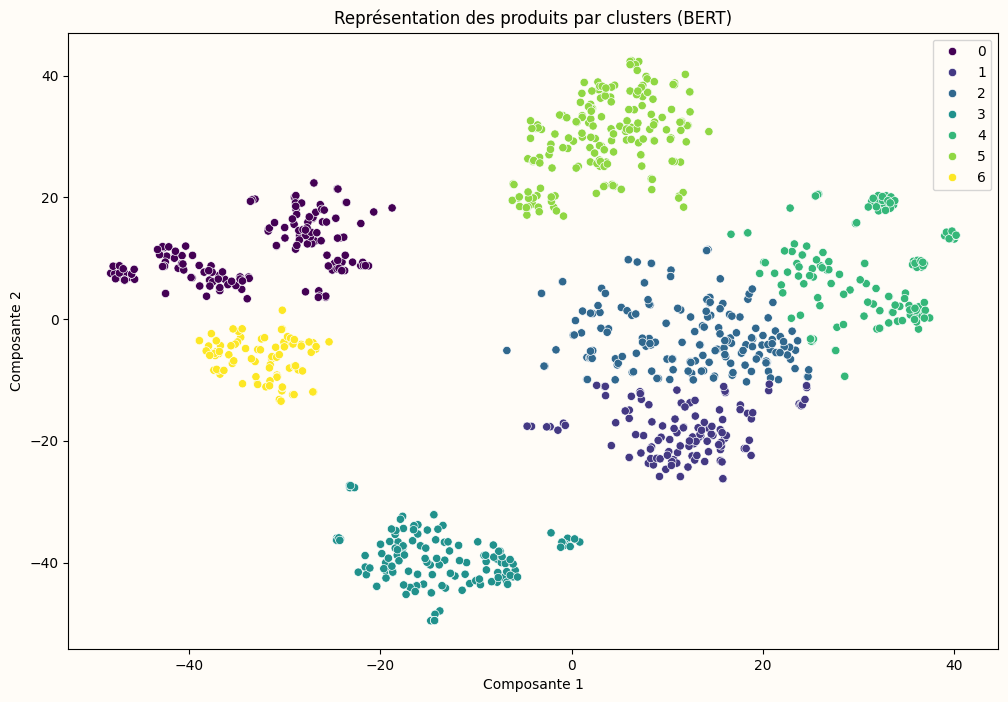

In [23]:
documents = df_cleaned['_tokenized'].tolist()
labels = df_cleaned['_category'].tolist()

# Charger le modèle BERT et le tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenization et extraction des embeddings avec BERT
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

X_bert = np.array([get_bert_embedding(doc) for doc in documents])
X_bert = X_bert.squeeze()

# Détermination du nombre de composants minimum pour capter un taux de variance acceptable. Ce nombre de composants est utilisé pour la réduction de dimensions.
visualize_scree_plot(
    matrix=X_bert, 
    n_components=300,
    title='Éboulis des valeurs propres (BERT)'
)

matrix_tsne_bert = visualize_categories_nlp(
    matrix=X_bert, 
    n_components_svd=150, 
    labels=labels, 
    title='Représentation des produits par catégories réelles (BERT)'
)

df_tsne_bert = check_ari_nlp(
    matrix=matrix_tsne_bert, 
    df_data=df_cleaned,
    title='ARI pour BERT'
)

visualize_tsne(
    df_data=df_tsne_bert, 
    hue='cluster', 
    title='Représentation des produits par clusters (BERT)',
    palette='viridis'
)

### <a id='toc6_4_3_'></a>[USE (Universal Sentence Encoder)](#toc0_)

USE convertit les phrases et les documents en vecteurs numériques qui capturent leur signification et les relations entre les mots.

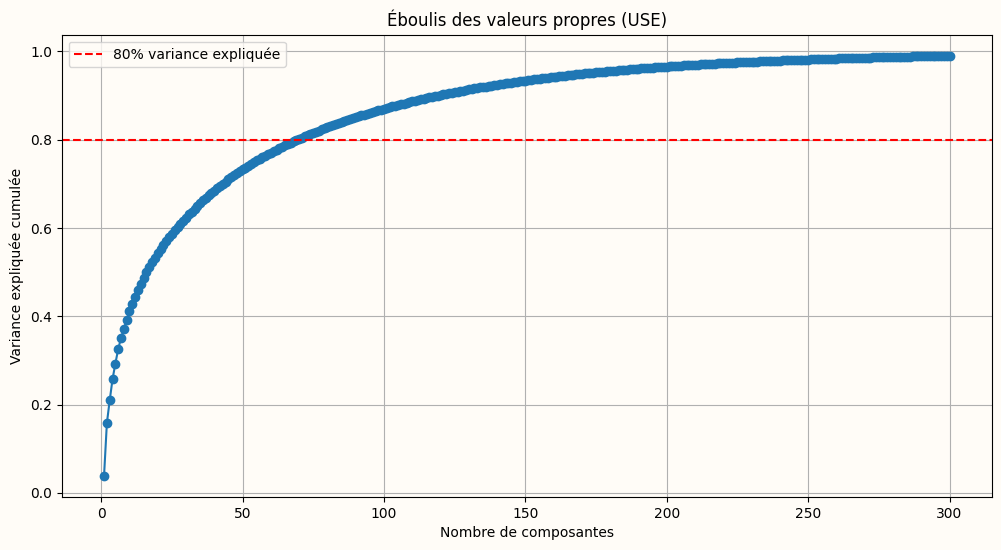

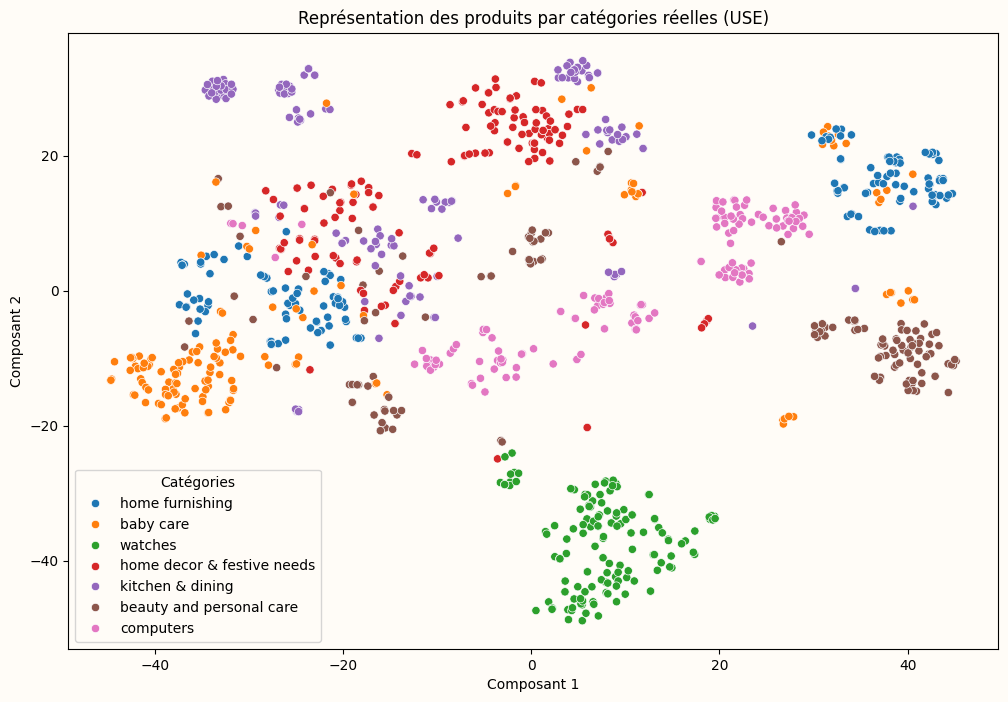

ARI pour USE 0.39840573044169975


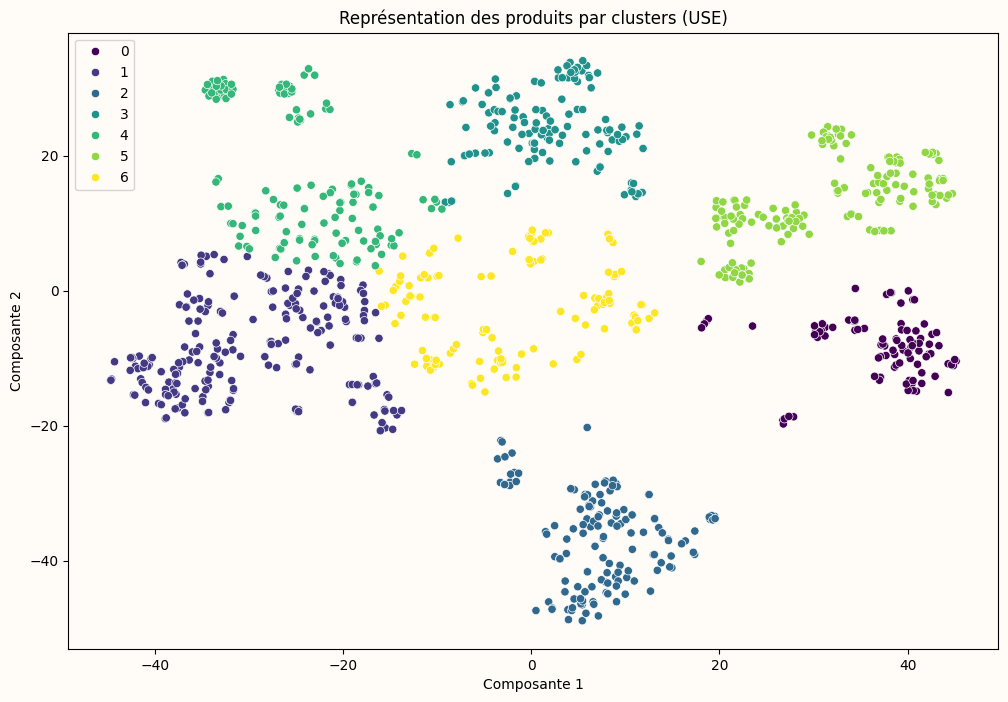

In [24]:
# Charger le modèle Universal Sentence Encoder localement
embed = hub.load('../models/universal-sentence-encoder-v2')

documents = df_cleaned['_tokenized'].tolist()
labels = df_cleaned['_category'].tolist()

X_use = embed(documents)

# Détermination du nombre de composants minimum pour capter un taux de variance acceptable. Ce nombre de composants est utilisé pour la réduction de dimensions.
visualize_scree_plot(
    matrix=X_use, 
    n_components=300,
    title='Éboulis des valeurs propres (USE)'
)

matrix_tsne_use = visualize_categories_nlp(
    matrix=X_use, 
    n_components_svd=150, 
    labels=labels, 
    title='Représentation des produits par catégories réelles (USE)'
)

df_tsne_use = check_ari_nlp(
    matrix=matrix_tsne_use, 
    df_data=df_cleaned,
    title='ARI pour USE'
)

visualize_tsne(
    df_data=df_tsne_use, 
    hue='cluster', 
    title='Représentation des produits par clusters (USE)',
    palette='viridis'
)

# <a id='toc7_'></a>[Étude de faisabilité : Computer Vision](#toc0_)

Cette partie examine la possibilité de classer les produits en fonction de leurs images. Pour cela, nous utilisons des techniques de vision par ordinateur (Computer Vision).

## <a id='toc7_1_'></a>[Chargement des données](#toc0_)

In [25]:
images_path_raw = '../datasets/flipkart/images/'
images_path_800_800 = '../datasets/flipkart/images_800_800/'
images = [file for file in listdir(images_path_raw)]
print(len(images))

1050


In [26]:
df_cleaned = df_cleaned[df_cleaned['uniq_id'] != '9743e6d1c9f3180483825fe4d2e97836']

## <a id='toc7_2_'></a>[Exploration et feature engineering](#toc0_)

Préparation du Dataframe qui sera utilisé dans les traitements qui suivent.

In [27]:
labels = df_cleaned['_category'].unique()

data_cv = pd.DataFrame()
data_cv['image'] = df_cleaned['image']
data_cv['image_path_raw'] = images_path_raw + df_cleaned['image']
data_cv['image_path_800_800'] = images_path_800_800 + df_cleaned['image']
data_cv['category'] = df_cleaned['_category']

with open('../models/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
data_cv['label'] = label_encoder.fit_transform(df_cleaned['_category'])

data_cv.head()

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                                     image_path_raw  \
0  ../datasets/flipkart/images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  ../datasets/flipkart/images/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  ../datasets/flipkart/images/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  ../datasets/flipkart/images/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  ../datasets/flipkart/images/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                                         image_path_800_800  \
0  ../datasets/flipkart/images_800_800/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  ../datasets/flipkart/images_800_800/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  ../datasets/flipkart/images_800_800/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  ../datasets/flipkart/images_800_800/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  ../datasets/flipkart/images_800_800/6325b6870c54cd47be6ebfbffa620ec7.jpg   

          category  label  
0  home furnishing      4  
1        baby care      0  
2        baby care      0  
3  home furnishing      4  
4  home furnishing      4

Chaque catégorie possède un nombre équivalent de produits et donc d'image de produit.

In [28]:
data_cv[['image', 'category']].groupby('category').count()

image
category                         
baby care                     150
beauty and personal care      150
computers                     149
home decor & festive needs    150
home furnishing               150
kitchen & dining              150
watches                       150

Les images à notre disposition sont de dimensions différentes.

Certaines images peuvent ressembler à des produits appartenant à une autre catégorie.

HOME FURNISHING


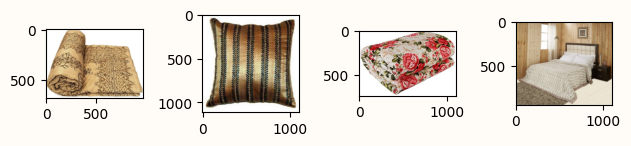

BABY CARE


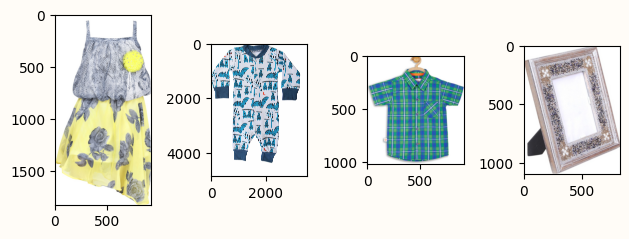

WATCHES


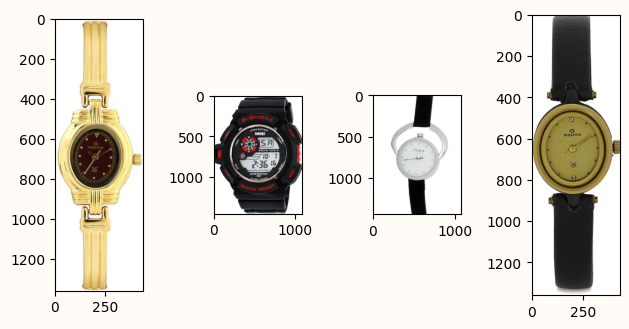

HOME DECOR & FESTIVE NEEDS


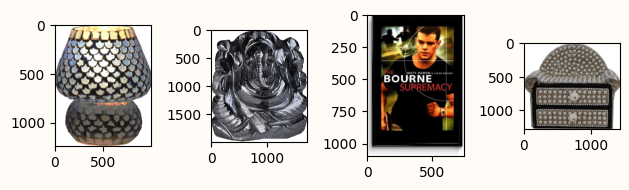

KITCHEN & DINING


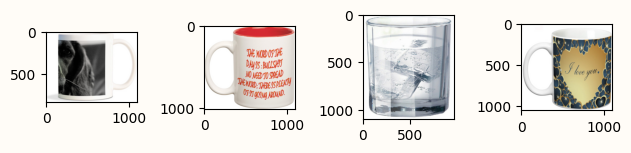

BEAUTY AND PERSONAL CARE


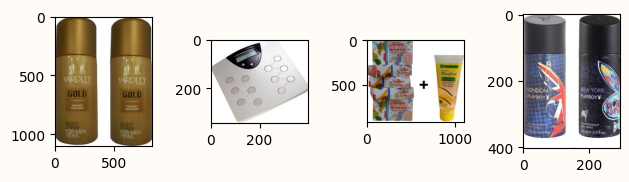

COMPUTERS


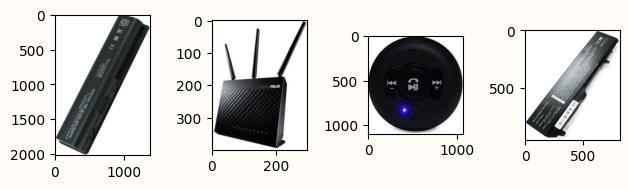

In [29]:
for category in data_cv['category'].unique() :
    print(f"{category.upper()}")
    filtered_df = data_cv[data_cv['category'] == category]
    random_rows = filtered_df.sample(n=4, random_state=42)

    for loop_index, (df_index, row) in enumerate(random_rows.iterrows()):
        plt.subplot(140 + 1 + loop_index)
        image = imread(row['image_path_raw'])
        plt.imshow(image)

    plt.tight_layout()
    plt.show()

## <a id='toc7_3_'></a>[Fonctions ré-utilisables pour le Computer Vision](#toc0_)

In [30]:
def preprocess_image(image_path: str):
    
    """
    Traite une image en appliquant plusieurs transformations.

    Cette fonction charge une image, la convertit en niveaux de gris, applique un filtre gaussien pour réduire le bruit,
    utilise l'égalisation de l'histogramme adaptatif pour améliorer le contraste, ajuste le contraste avec la correction gamma,
    redimensionne l'image tout en conservant le rapport d'aspect, et ajoute des bordures pour obtenir une taille fixe de 800x800 pixels.

    Args:
        image_path (str): Le chemin vers l'image à traîter.

    Returns:
        np.ndarray: L'image traîté sous forme de tableau numpy.
    """

    # Charger l'image en niveaux de gris
    preprocessed_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Appliquer un filtre gaussien pour réduire le bruit
    preprocessed_image = cv2.GaussianBlur(preprocessed_image, (11, 11), 0)
    
    # Appliquer l'égalisation de l'histogramme adaptatif (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    preprocessed_image = clahe.apply(preprocessed_image)
    
    # Appliquer la correction gamma pour augmenter le contraste
    gamma = 2.0
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    preprocessed_image = cv2.LUT(preprocessed_image, table)
    
    # Redimensionner l'image tout en conservant le rapport d'aspect
    target_size = 800
    h, w = preprocessed_image.shape
    scale = target_size / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    preprocessed_image = cv2.resize(preprocessed_image, (new_w, new_h))
    
    # Ajouter des bords pour obtenir une taille fixe (800x800)
    top = (target_size - new_h) // 2
    bottom = target_size - new_h - top
    left = (target_size - new_w) // 2
    right = target_size - new_w - left
    preprocessed_image = cv2.copyMakeBorder(preprocessed_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    
    return preprocessed_image

In [31]:
def build_df_tsne(features: np.ndarray) -> tuple[np.ndarray, pd.DataFrame]:
    """
    Applique t-SNE sur un ensemble de caractéristiques et construit un DataFrame contenant les résultats.

    Parameters:
    -----------
    features : np.ndarray
        Tableau Numpy des caractéristiques à transformer par t-SNE.

    Returns:
    --------
    tuple[np.ndarray, pd.DataFrame]
        Un tuple contenant :
        - np.ndarray : Les caractéristiques transformées par t-SNE.
        - pd.DataFrame : Un DataFrame contenant les deux premières dimensions t-SNE et les informations de catégorie et d'étiquette.
    """

    # Initialisation du modèle t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)

    # Transformation des caractéristiques d'entrée par t-SNE.
    X_tsne = tsne.fit_transform(features)

    # Construction du DataFrame avec les résultats t-SNE.
    df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne_1', 'tsne_2'])
    
    # Utilisation des index de 'data_cv' pour conserver la cohérence avec les données d'origine.
    df_tsne.index = data_cv.index
    
    # Ajout des colonnes 'category' et 'label'
    df_tsne['category'] = data_cv['category']
    df_tsne['label'] = data_cv['label']

    print(df_tsne.shape)
    
    # Retourne le tableau t-SNE et le DataFrame.
    return (X_tsne, df_tsne)

In [32]:
def check_ari_cv(matrix: np.ndarray, df_data: pd.DataFrame, title: str):
    """
    Calcule et affiche le score Adjusted Rand Index (ARI) pour une matrice de données donnée en utilisant KMeans.

    Parameters:
    -----------
    matrix : np.ndarray
        Matrice des données à utiliser pour le clustering.
    df_data : pd.DataFrame
        DataFrame contenant les données originales, incluant les colonnes 'category' et 'label'.
    title : str
        Titre pour l'affichage des résultats du score ARI.

    Returns:
    --------
    None
        Cette fonction affiche directement le score ARI et ne retourne aucune valeur.
    """

    # Détermination du nombre de clusters (K) à partir du nombre de catégories uniques dans les données.
    k = len(df_data['category'].unique())
    
    # Initialisation du modèle KMeans avec K clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Ajustement du modèle KMeans à la matrice de données.
    kmeans.fit(matrix)
    
    # Ajout des étiquettes de clusters obtenues par KMeans au DataFrame original.
    df_data['cluster'] = kmeans.labels_

    # Calcul et affichage du score Adjusted Rand Index (ARI).
    print(f"{title} : ", adjusted_rand_score(df_data['label'], df_data['cluster']))

In [33]:
def build_histograms(k: int, vectors_concat: list, vectors_local: list) -> np.ndarray:
    """
    Construit des histogrammes de fréquence basés sur les prédictions de KMeans pour une liste de vecteurs locaux.

    Parameters:
    -----------
    k : int
        Le nombre de clusters à utiliser pour KMeans.
    vectors_concat : list
        Liste des vecteurs concaténés pour ajuster le modèle KMeans.
    vectors_local : list
        Liste des vecteurs locaux pour lesquels les histogrammes seront construits.

    Returns:
    --------
    np.ndarray
        Un tableau Numpy contenant les histogrammes de fréquence pour chaque vecteur local.
    """

    histograms = []

    # Initialisation de MiniBatchKMeans avec k clusters
    mini_batch_kmeans = MiniBatchKMeans(n_clusters=k, n_init=k, random_state=42)
    
    # Ajustement du modèle KMeans avec les vecteurs concaténés.
    mini_batch_kmeans.fit(vectors_concat)

    # Construction des histogrammes pour chaque vecteur local.
    for vector_local in vectors_local:
        # Prédiction des clusters pour le vecteur local.
        prediction = mini_batch_kmeans.predict(vector_local)
        
        # Construction de l'histogramme basé sur les prédictions.
        histogram, _ = np.histogram(prediction, bins=np.arange(len(mini_batch_kmeans.cluster_centers_)+1), density=True)
        
        # Ajout de l'histogramme à la liste des histogrammes.
        histograms.append(histogram)

    # Conversion de la liste des histogrammes en tableau Numpy et retour du résultat.
    return np.asarray(histograms)

In [34]:
def visualize_random_histograms(features: np.ndarray):
    """
    Visualise des histogrammes de fréquences pour des échantillons pris au hasard à partir d'un tableau de caractéristiques.

    Parameters:
    -----------
    features : np.ndarray
        Tableau Numpy contenant les histogrammes de caractéristiques pour chaque échantillon. 

    Returns:
    --------
    None
        Cette fonction affiche directement les histogrammes et ne retourne aucune valeur.
    """

    # Sélection de trois indices aléatoires à partir des caractéristiques.
    random_indices = random.sample(range(features.shape[0]), 3)

    fig, axes = plt.subplots(3, 1, figsize=(12, 8))

    # Affichage de chaque histogramme sélectionné aléatoirement.
    for ax, idx in zip(axes, random_indices):
        histogram = features[idx]
        ax.bar(range(len(histogram)), histogram)
        ax.set_title(f'Histogramme des mots visuels pour l\'image {idx}')
        ax.set_xlabel('Mot visuel (index)')
        ax.set_ylabel('Fréquence')

    plt.tight_layout()
    plt.show()

## <a id='toc7_4_'></a>[Méthode basique : SIFT](#toc0_)

**Constat global**

Le score ARI obtenu avec SIFT est de 0.06, indiquant une faible corrélation entre les clusters prédits et les catégories réelles. De plus, une analyse visuelle des graphiques montre que les clusters ne sont pas bien séparés et présentent un chevauchement important entre les catégories. 

Ces résultats révèlent que SIFT, même avec différents prétraitements d'image, ne réussi pas à capturer efficacement les caractéristiques discriminantes des produits, ce qui nous laisse insatisfaits quant à sa performance.

### <a id='toc7_4_1_'></a>[Exemple de traitement d'image : extraction de descripteurs](#toc0_)

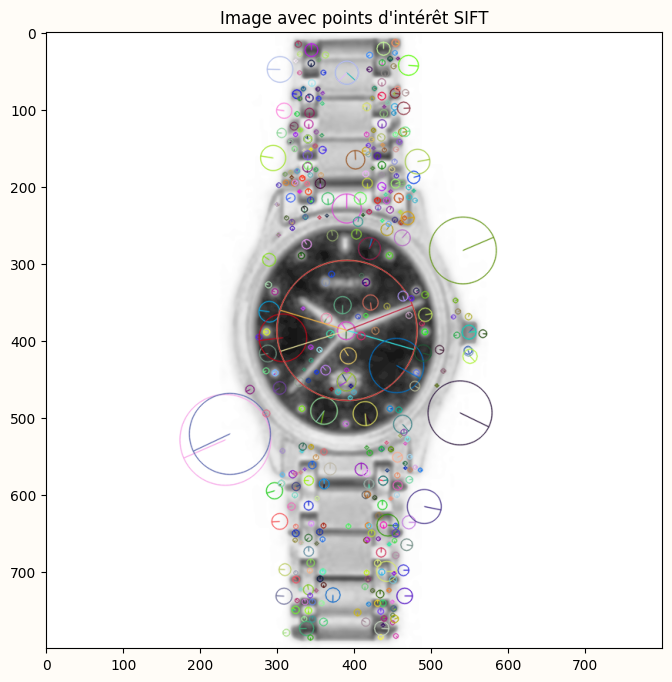

Descripteurs : (467, 128)

[[  0.   0.   6. ...   0.   0.   0.]
 [  0.   1.  11. ...   0.   0.   0.]
 [158.  86.   0. ...   0.   0.   5.]
 ...
 [135.  98.   4. ...   0.   0.   5.]
 [  0.  23. 136. ...   0.   0.   0.]
 [ 18. 137. 105. ...   0.   0.   0.]]


In [35]:
image_path = images_path_800_800 + '087e83a2406dc98d941b8555356da477.jpg'

nb_keypoints = 1000
sift = cv2.SIFT_create(nb_keypoints)

preprocessed_image = preprocess_image(image_path)
keypoints, descriptors = sift.detectAndCompute(preprocessed_image, None)

image_with_keypoints = cv2.drawKeypoints(preprocessed_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(8,8))
plt.imshow(image_with_keypoints)
plt.title('Image avec points d\'intérêt SIFT')
plt.show()

print(f"Descripteurs : {descriptors.shape}")
print(f"\n{descriptors}")

### <a id='toc7_4_2_'></a>[Extraction des descripteurs locaux propres à chaque image](#toc0_)

In [36]:
sift = cv2.SIFT_create(nb_keypoints)
sift_descriptors = {}
sift_descriptors_local = []

# Extraire les descripteurs de chaque image
for loop_index, (df_index, row) in enumerate(data_cv.iterrows()):
    preprocessed_image = preprocess_image(row['image_path_raw'])
    keypoints, descriptors = sift.detectAndCompute(preprocessed_image, None)
    sift_descriptors[row['image']] = descriptors

# Descripteurs par image
for image_name, descriptor in sift_descriptors.items():
    if descriptor is None or len(descriptor) <= 0:
        print(f"Descripteurs non valides pour l'image : {image_name}")
    else:
        sift_descriptors_local.append(descriptor)

# Tous les descripteurs
sift_descriptors_concat = np.concatenate(sift_descriptors_local, axis=0)
print(f"Nombre total de descripteurs : {sift_descriptors_concat.shape}")

Nombre total de descripteurs : (672619, 128)


## <a id='toc7_5_'></a>[Bag of Visual Words (BoVW) : descripteurs globaux](#toc0_)

L'objectif principal de cette étape est de convertir les descripteurs locaux (SIFT) en un descripteur global compact pour chaque image sous forme d'histogramme de mots visuels.

### <a id='toc7_5_1_'></a>[Histogrammes de mots visuels](#toc0_)

In [37]:
sift_descriptors_global = build_histograms(k=300, vectors_concat=sift_descriptors_concat, vectors_local=sift_descriptors_local)

### <a id='toc7_5_2_'></a>[Exemples d'histogramme](#toc0_)

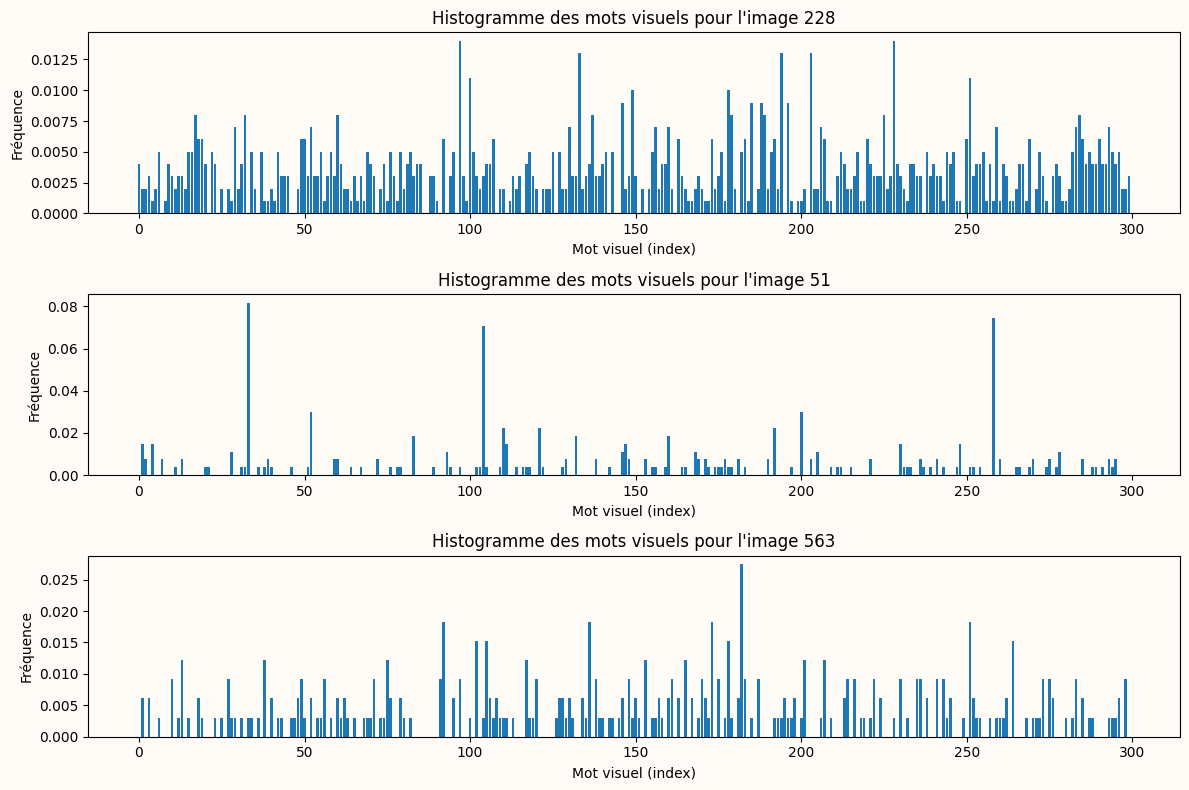

In [38]:
visualize_random_histograms(features=sift_descriptors_global)

## <a id='toc7_6_'></a>[Analyse visuelle : affichage T-SNE](#toc0_)

(1049, 4)


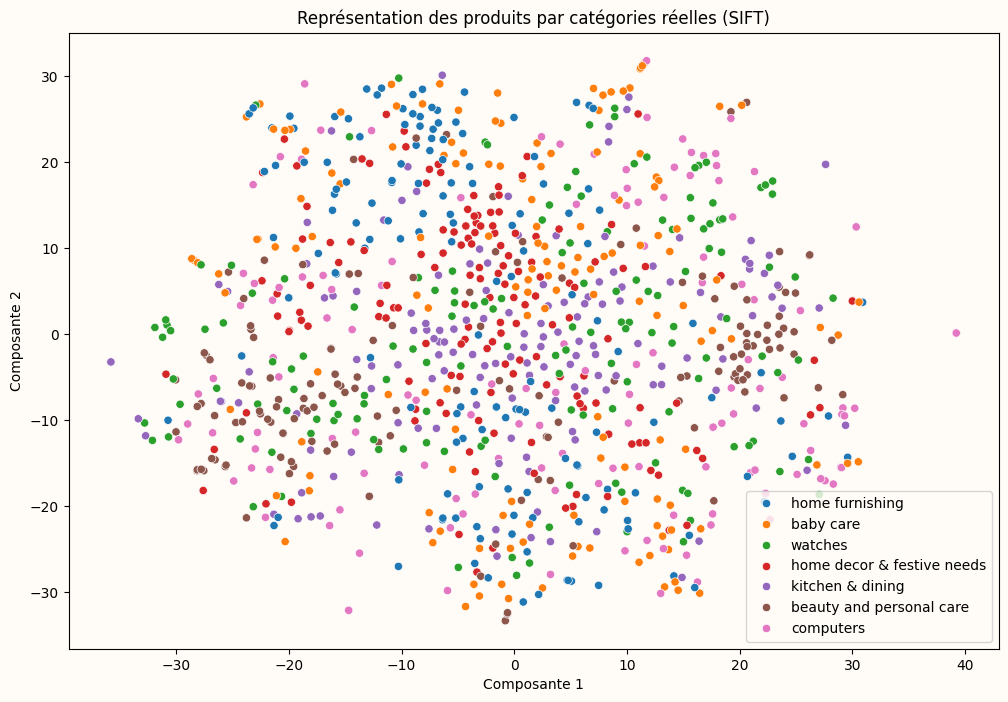

In [39]:
X_tsne_sift, df_tsne_sift = build_df_tsne(features=sift_descriptors_global)

visualize_tsne(
    df_data=df_tsne_sift, 
    hue='category', 
    title='Représentation des produits par catégories réelles (SIFT)',
    palette='tab10'
)

In [40]:
check_ari_cv(
    title='ARI pour SIFT', 
    matrix=X_tsne_sift, 
    df_data=df_tsne_sift
)

ARI pour SIFT :  0.06371159984421527


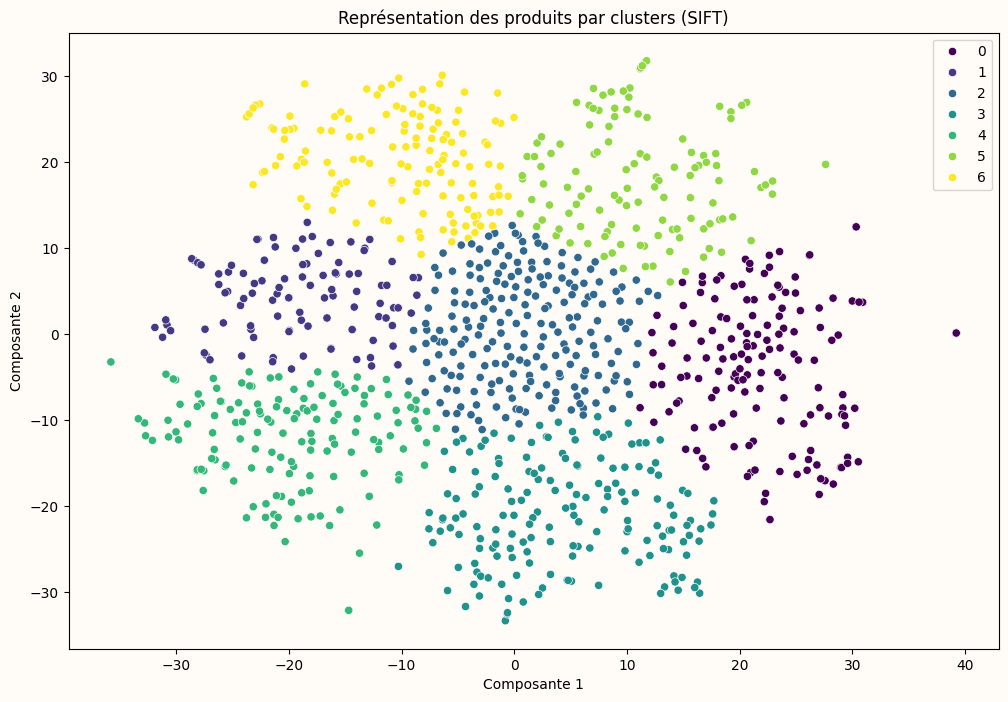

In [41]:
visualize_tsne(
    df_data=df_tsne_sift, 
    hue='cluster', 
    title='Représentation des produits par clusters (SIFT)',
    palette='viridis'
)

## <a id='toc7_7_'></a>[Méthode avancée : CNN Transfer Learning](#toc0_)

**Constat global**

Nous avons exploré la possibilité d'utiliser des techniques avancées de traitement d'image pour la classification automatique de produits. Les résultats obtenus à partir des features extraites avec le modèle VGG16 sont prometteurs.

Ces résultats montrent qu'il est possible de répondre de manière affirmative à la demande d'étude de faisabilité de classification automatique en utilisant des techniques de traitement d'image avancées. Avec des ajustements supplémentaires et potentiellement l'utilisation de modèles plus sophistiqués ou des approches hybrides, nous pouvons espérer améliorer encore la précision de la classification.

### <a id='toc7_7_1_'></a>[Extraction des features locales propres à chaque images](#toc0_)

In [42]:
# Charger le modèle VGG16 sans la dernière couche
vgg_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_pool').output)

vgg_features = {}
vgg_features_local = []
vgg_features_concat = []

# Fonction pour prétraiter l'image
def preprocess_image_cnn(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Extraire les features de chaque image
for loop_index, (df_index, row) in enumerate(data_cv.iterrows()):
    preprocessed_image = preprocess_image_cnn(row['image_path_800_800'])
    features = model.predict(preprocessed_image, verbose=0) # Extraire les features de l'image
    features = features.reshape(-1, 512)                    # Réorganiser les features en un vecteur
    vgg_features[row['image']] = features

# Features par image
for image_name, features in vgg_features.items():
    vgg_features_local.append(features)
print(f"Nombre d'images avec des features : {len(vgg_features_local)}")

# Toutes les features
vgg_features_concat = np.concatenate(vgg_features_local, axis=0)
print(f"Nombre total de features : {vgg_features_concat.shape}")

Nombre d'images avec des features : 1049
Nombre total de features : (51401, 512)


### <a id='toc7_7_2_'></a>[Bag of Visual Words (BoVW) : features globales](#toc0_)

#### <a id='toc7_7_2_1_'></a>[Histogrammes de mots visuels](#toc0_)

In [43]:
vgg_features_global = build_histograms(k=200, vectors_concat=vgg_features_concat, vectors_local=vgg_features_local)

#### <a id='toc7_7_2_2_'></a>[Exemples d'histogramme](#toc0_)

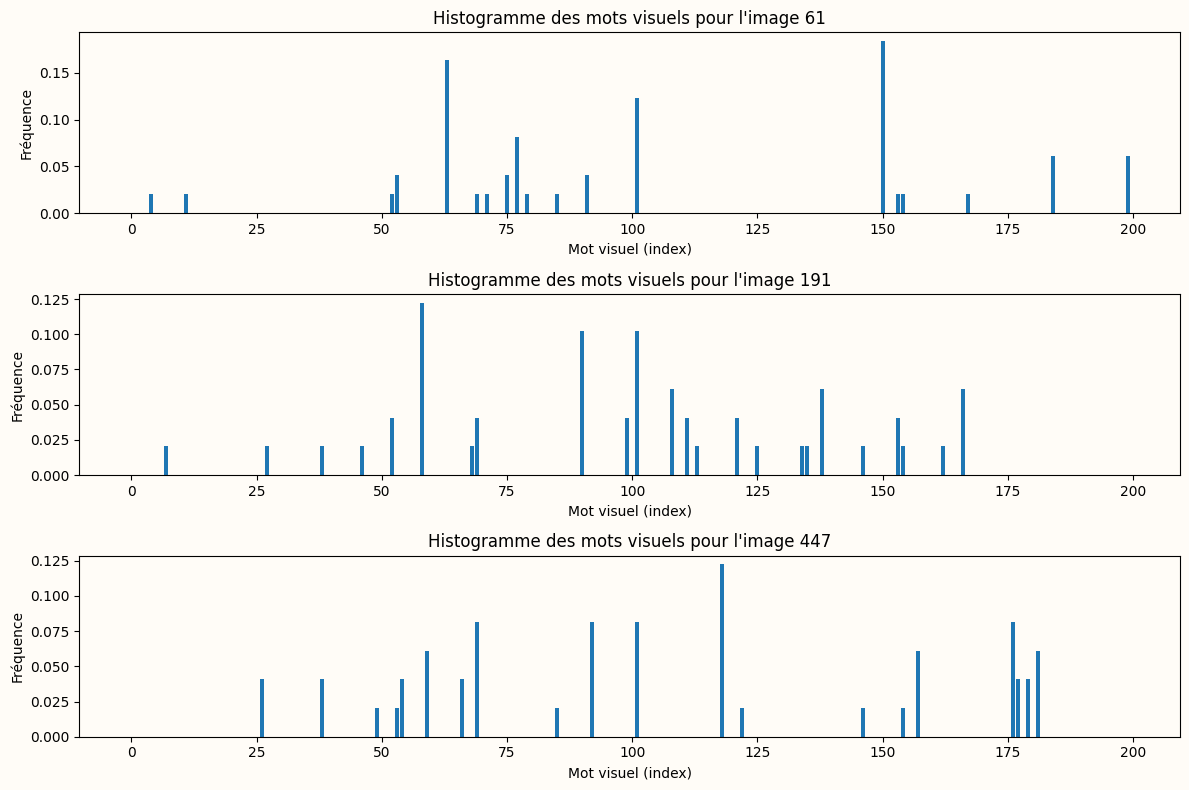

In [44]:
visualize_random_histograms(features=vgg_features_global)

### <a id='toc7_7_3_'></a>[Analyse visuelle : affichage T-SNE](#toc0_)

(1049, 4)


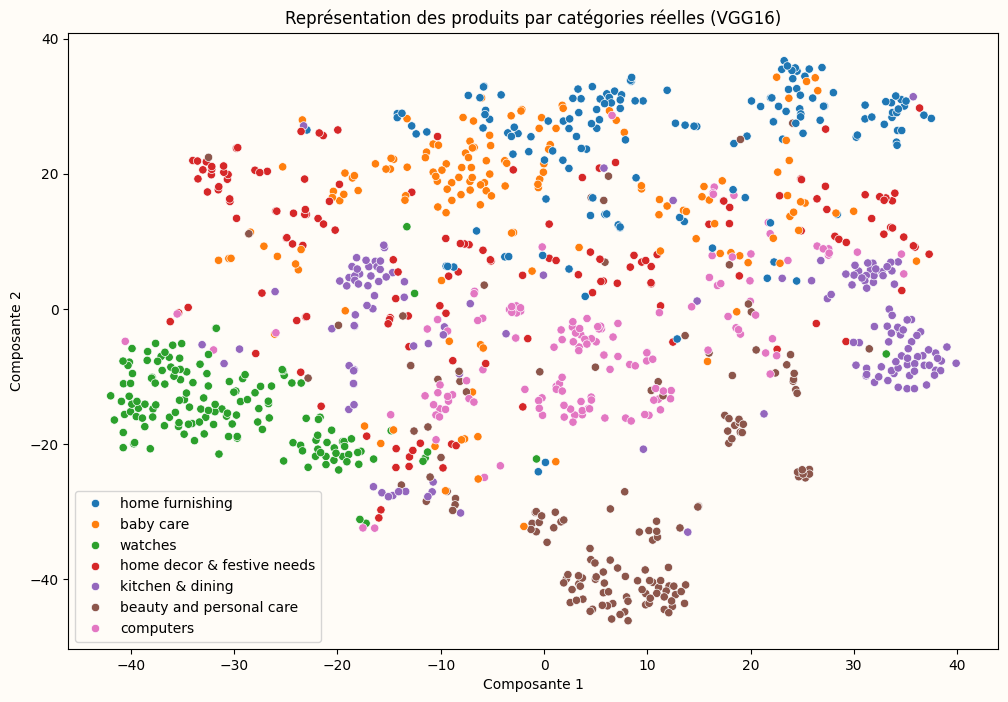

In [45]:
X_tsne_vgg, df_tsne_vgg = build_df_tsne(features=vgg_features_global)

visualize_tsne(
    df_data=df_tsne_vgg, 
    hue='category', 
    title='Représentation des produits par catégories réelles (VGG16)', 
    palette='tab10'
)

In [46]:
check_ari_cv(
    title='ARI pour VGG16', 
    matrix=X_tsne_vgg, 
    df_data=df_tsne_vgg)

ARI pour VGG16 :  0.33468879936657664


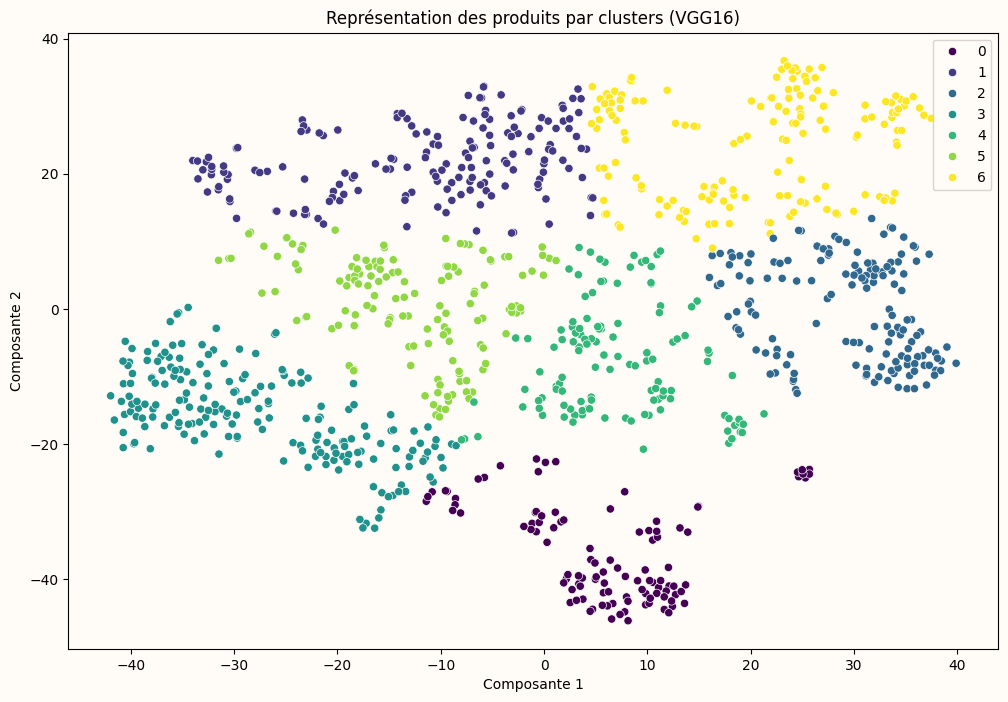

In [47]:
visualize_tsne(
    df_data=df_tsne_vgg, 
    hue='cluster', 
    title='Représentation des produits par clusters (VGG16)',
    palette='viridis'
)

# 